# Coupled Model Intercomparison Project (CMIP)

In this notebook we will introduce the basics of the Coupled Model Intercomparison Project (CMIP), which is coordinated by the world climate research program (WCRP). Note that this notebook contains a short summary, more details are available in the handout.

To use this notebook you will need the following python packages installed 
- cdsapi
- cdo
- matplotlib
- numpy

In the 70s and 80s, it was very difficult to assess the range on uncertainties of future climate projections, and indeed to partition these into contributions from model, forcing and initial conditions, due to the fact that different modelling centres ran different experiments with different boundary conditions ($CO_2 pathways) and so on.

Thus, CMIP began in 1995 under the auspices of the Working Group on Coupled Modelling (WGCM).  The first set of common experiments involved comparing the model response to an idealized forcing, a constant rate of increase which was accomplished using a CO$_2$ increase of 1\% per year compounded. Since that time a number of CMIP experiments have been developed. The experiments continue to include integrations using idealized forcings to facilitate understanding. They now also include integrations forced with estimates of the changes in the historical radiative forcings as
well as estimates of the future changes.

Note that CMIP and IPCC are separate, even if closely linked.  CMIP is a coordination project for climate model intercomparisons in a fairly controlled framework, while the role of IPCC is to summarize the state of climate science (see the lecture notes for more details on IPCC). These days there is close coordination, with a new round of CMIP designed to feed into the IPCC summary (in fact CMIP4 was skipped to bring the round numbers together, so that CMIP5 fed into IPCC assessment report 5), but IPCC can cast the umbrella wider and summarizes a lot of science not directly linked to CMIP (e.g. cloud resolving model experiments, observational studies and so on). 



## The present day design, DECK

CMIP arranges a common experimental framework consisting of compulsory core experiments and a range of optional experiments that investigate scientific questions deeper,  such as the role of land-atmosphere interactions, or the impact of  accurate initialization of ocean conditions to perform near-term decadal prediction. In the upcoming 6$^{th}$ assessment report the core experiments are
now known as CMIP Diagnostic, Evaluation and Characterization of Klima
(DECK) \index{CMIP!DECK} experiments \cite{eyring:16}

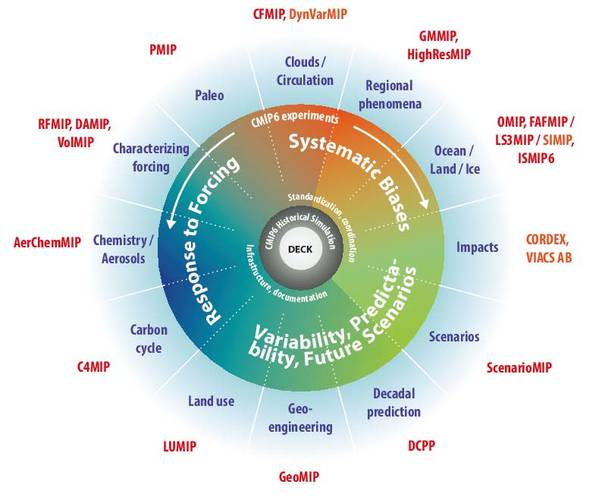 DECK experiments of CMIP6


- The modelling centres are free to choose their model set up (e.g. horizontal and vertical resolutions), thus model uncertainties consist of both structural uncertainties pertaining to physical parameterization choices and numerical methods, as well as the model resolution choices.  
- Also the method to initialize the model runs is left to the discretion of the modeller, with the exception of the decadal initialized experiments that are part of CMIP5 and CMIP6.
- Thus the key element of the coordination is in the specification of the boundary conditions in terms of the atmospheric composition of radiatively active gases (or alternatively their anthropogenic sources), and increasingly the land cover conditions.



## Representative Concentration Pathways (RCPs)
Part of the CMIP process is the definition of potential boundary conditions for the future. As stated earlier, in early rounds of CMIP, experiments were very simple in design consisting of instantaneous doubling of CO$_2$ or increasing CO$_2$ by a fixed percentage each year.

Although these experiments are retained in DECK, CMIP5 has introduced the concept of Representative Concentration Pathways (RCPs) for future greenhouse gas and aerosol concentrations (or emissions for interactive carbon cycle experiments) (Fig. ref{fig:rcp1}). The RCPs for CMIP5 are generally referred to by the magnitude of the TOA radiative forcing ($\Delta R$ in W m$^{-2}$) expected at the end of the 21$^{st}$ century, namely RCP2.6, RCP4.5, RCP6.0 and RCP8.5 for CMIP5 (supplemented by intermediate scenarios in CMIP6).

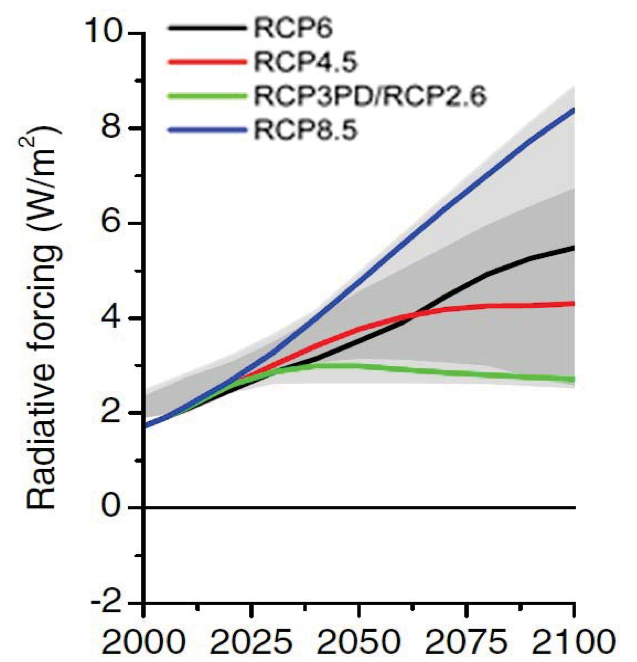
To produce these, four modelling groups were selected and tasked with producing RCPs that spanned the range of
over 100 studies existing in the literature, ranging from a low-end emission scenario to a high-end scenario.


## shared socioeconomic pathway (SSP)

These scenarios are built around a storyline for economic development, population growth and government policy, in particular for energy generation (e.g. nuclear, fossil fuels, solar, biofuels).  As each group was tasked separately to come up with a scenario for a given radiative forcing, there can be considerable overlap in the socioeconomic assumptions of the scenarios, referred to as the shared socioeconomic pathway (SSP). For example, Fig. \ref{fig:rcp_gdp_pop} shows similarlity in the population growth projections of the first three RCPs (2.6, 4.5 and 6.0), with population asymptoting to around 9 billion, while RCP8.5 sees the population reaching 12 billion individuals, each with their own carbon footprint. 

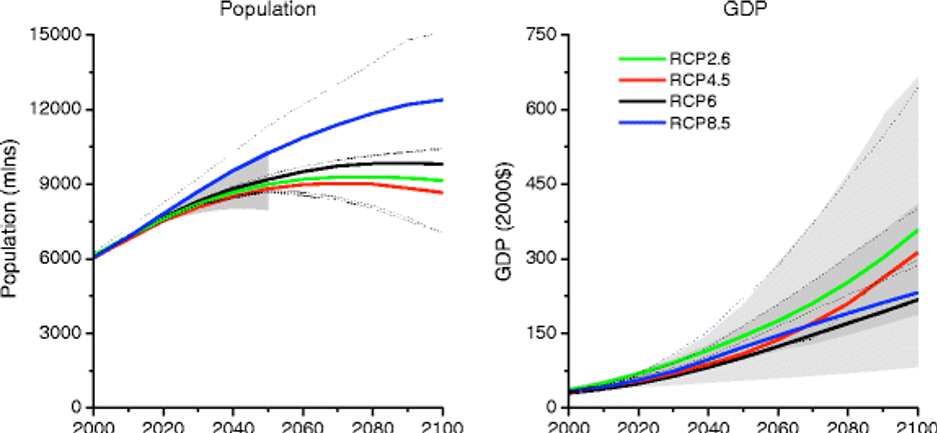

The population growth leads to changes in land use change due to food requirements, and also for energy, resulting potential pathways for anthropogenic land cover change.  RCP2.6 has a low emissions scenario, but the natural vegetation cover change in Africa actually exceeds that in RCP8.5!

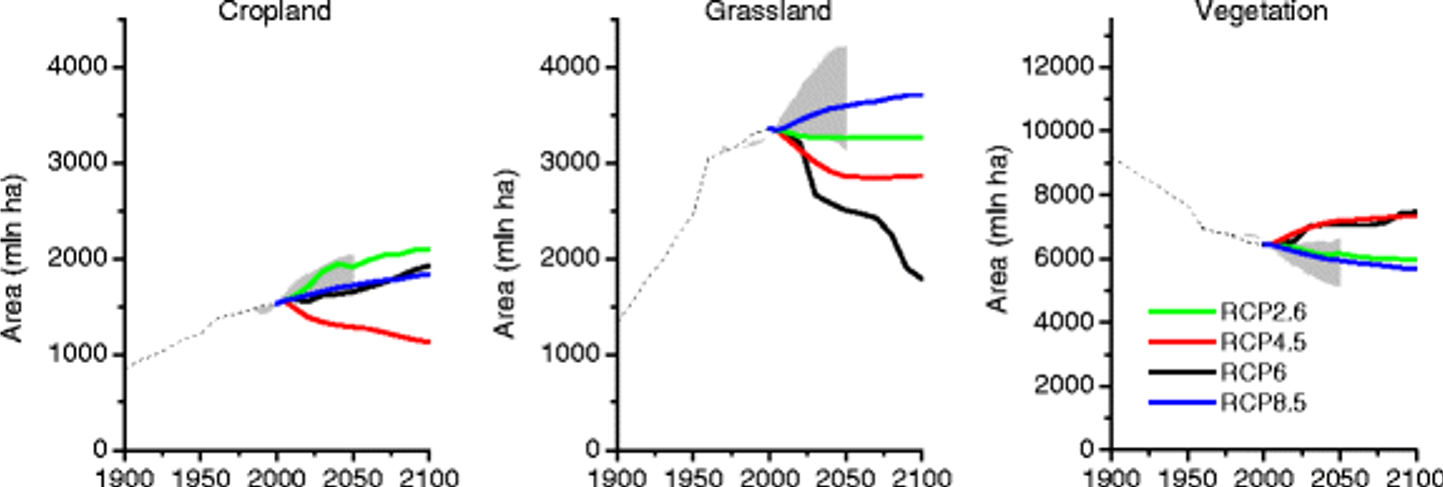

# Obtaining CMIP6 data

The official way to retrieve data is through the Earth System Grid (ESM), a system of mirror site nodes which host **all** the CMIP6 output. However, a subset of the main data is now available on the CDS which we know how to access using the webapi.  Details of the data available here https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=overview

Hang on though, we are going too fast, before we get going let's import all the other packages we need in one place here before we move on...


In [2]:
# import all the packages we will need for this lesson
import zipfile
import glob
import cdsapi
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
from cdo import *
import numpy as np
import datetime
from pathlib import Path


Right, now let's get going... You can click on the link above to browse the CMIP6 data.  You will see that you are restricted unfortunately to downloading one model at a time with the web interface.  We will look at the near surface air temperature for the Noresm model, using monthly data.

Selecting the data and click on the API window, you should see something like this code snippet below, but here we have altered it to a function, to which we can pass the model name  - this will be useful later if we want to compare several models. I have also edited the code to place the data in a different directory, you can run this directly but make sure you are in a scratch directory with at least 120MB of space.  

In [3]:
# python code for getting code

odir="/Users/tompkins/junk/"
#odir="/scratch/tompkins/cmip"
Path(odir).mkdir(parents=True,exist_ok=True)

def get_var(model,var,exp):

    c = cdsapi.Client()
    
    # This is where you want to put your output directory and file name
    ofile=odir+model+"_"+var+"_"+exp+".zip"

    c.retrieve(
    'projections-cmip6',
    {
        'format': 'zip',
        'temporal_resolution': 'monthly',
        'experiment': exp,
        'level': 'single_levels',
        'variable': var,
        'model': model,
    },
    ofile)
    
    return ofile


In [ ]:

# let's try it out 
model='noresm2_mm'
var="near_surface_air_temperature"
exp='ssp5_8_5'

ofile=get_var(model,var,exp)

now we need to unzip the files and then pass results to a variable as a list.

In [4]:
# unzip file call to shell to detar and examine header
def unzip_cmip(ofile):
    """unzips the zip file and returns the contents list"""
    with zipfile.ZipFile(ofile,"r") as zip_ref:
        zip_ref.extractall(odir)
        files=zip_ref.namelist()[:-2] # keep only .nc files
        return(files)

In [ ]:
# let's try it out
print("ofile was ",ofile)
files=unzip_cmip(ofile)
print(files)

That worked, so now let's take a look at the header of one of the files (recall you can also do this using ncdump from the command line)


In [ ]:
# CDO from python to do some stats, fldmeans and means at start, and at end 
ds=Dataset(odir+files[0])
ds.variables

So the key variable is called **tas**

## Time series of global mean temperatures.

Now we are going to use cdo to make global means and spatial means of the climate data output



In [5]:
def make_ts_yearmean(files):
    """cdo based routine to make annual and fldmean, merging section files"""
    
    # set cdo to an incidence of Cdo(), you don't need to do this, but cdo.func is neater than Cdo().func
    cdo = Cdo()

    # this illustrates one advantage of cdo within python, the ability to auto handle tmp files...
    mfile=[]
    for file in files:
        mfile.append(cdo.fldmean(input=odir+file)) # look, no output :-) 
    ofile=odir+files[0][:-16]+"fldmean_yearmean.nc"
    cdo.yearmean(input=cdo.mergetime(input=mfile),output=ofile,options="-O ")
    return ofile


In [ ]:
# let's try it out 
tsfile=make_ts_yearmean(files)

# check if the file is there:
annmean=glob.glob(odir+"*fldmean_yearmean.nc")
print(annmean)

you should see a list with the file as the only string if everything has worked okay.  You   can open that file from the command line using **ncview** if you like (go on, give it a try!)... but let's also plot it here:

In [6]:
# let's try a plot

def plot_base(tsfile,var):
    ds=Dataset(tsfile)
    time=ds.variables['time']
    years=[i.year for i in num2date(time,time.units,only_use_python_datetimes=True)]
    xvar=ds.variables[var]

    fig,ax=plt.subplots()
    ax.set_title(ds.getncattr("experiment_id"))
    ax.set_xlabel('year')
    ax.set_ylabel(xvar.long_name+" ("+xvar.units+")")
    
    ax.plot(years,xvar[:,0,0],label=ds.getncattr("source_id"))
    return fig,ax

In [ ]:
fig,ax=plot_base(tsfile,"tas")
ax.legend()

### Questions

- What is the temperature increase globally over the century period?
- Does the temperature increase linearly, or are there signs of an accelerating trend?
- Is the trend constant or do you see decades where temperature is not increasing?

Let's make an intercomparison between different models now...  

In [ ]:
# If you cut and paste the model title note that you need to change "-" to "_" 
models=["CanESM5","MPI_ESM1_2_LR","CMCC_CM2_SR5","MIROC6","NorESM2_MM","HadGEM3_GC31_MM"]
models=[s.lower() for s in models] # and convert to lower case too...
exp='ssp5_8_5'

# process the files and make the timeseries
zipfiles=[]
for model in models:
    zipfiles.append(get_var(model,var,exp))



In [ ]:
# commented out, zipfiles is defined in the previous cell - this was just a fudge
# zipfiles=glob.glob(odir+"*.zip")
tsfiles=[]
for zfile in zipfiles:
    tsfiles.append(make_ts_yearmean(unzip_cmip(zfile)))
    

As we want to plot multiple models, we also need a function to add a line to an existing plot

In [7]:
# now let's make the plot 
def plot_add(file,var,ax):
    ds=Dataset(file)
    time=ds.variables['time']
    dtime=num2date(time,time.units,only_use_python_datetimes=True)
    years=[i.year for i in dtime]
    xvar=ds.variables[var]    
    ax.plot(years,xvar[:,0,0],label=ds.getncattr("source_id"))


And now we will plot the randomly selected models

In [ ]:
var="tas"
for i,file in enumerate(tsfiles):
    if i==0:
        fig,ax=plot_base(str(file),var)
    else:
        plot_add(file,var,ax)
# uncomment if you only want to 2100
ax.set_xlim([2000,2100])
ax.set_ylim([287,295])
ax.legend()

## Questions
- Do all the models agree on the trend?
- Why do you think the models disagree on the temperature for 2015 at the start of the experiment?
- If you had to communicate the uncertainty to a decision maker what would you do?


## Exercises

- For a single model and RCP8.5, Compare surface temperature to the near surface temperature - in which parameter are the changes largest, and try to explain why
- Get the TOA SW and LW net fluxes (start with one model, you can expand later) for the 4 main RCPs.
- Plot a series of the TOA net flux for all RCP
- Compare this to the RCP radiative forcing in the figure at the top of this notebook
- What are the similarities and what are the key differences?  Which is lowest the TOA flux imbalance or the forcing? Do you understand why?  tsfiles=[]
for zfile in zipfiles:
    tsfiles.append(make_ts_yearmean(unzip_cmip(zfile)))
 

# TOA fluxes

so once you have tried the exercise, let's have a look at the TOA fluxes...

In [10]:
# so let's get the TOA fluxes now
models=["CanESM5","CMCC-CM2-SR5","MIROC6","NorESM2-MM"]
#models=[s.lower() for s in models] # and convert to lower case too...
exp='ssp585'

varlist=['toa_outgoing_shortwave_radiation','toa_outgoing_longwave_radiation']
# process the files and make the timeseries
zipfiles=[]
for model in models:
    for var in varlist:
        print(var,model)
        zipfiles.append(get_var(model,var,exp))

2021-05-27 12:23:04,626 INFO Welcome to the CDS
2021-05-27 12:23:04,627 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6


toa_outgoing_shortwave_radiation CanESM5


2021-05-27 12:23:04,702 INFO Request is completed
2021-05-27 12:23:04,703 INFO Downloading https://download-0003.copernicus-climate.eu/cache-compute-0003/cache/data2/adaptor.esgf_wps.retrieve-1622025371.8238087-32079-4-94713805-b40a-421f-a6d5-3cda65038591.zip to /Users/tompkins/junk/CanESM5_toa_outgoing_shortwave_radiation_ssp585.zip (90M)
2021-05-27 12:23:32,727 INFO Download rate 3.2M/s   
2021-05-27 12:23:32,838 INFO Welcome to the CDS
2021-05-27 12:23:32,839 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2021-05-27 12:23:32,912 INFO Request is completed
2021-05-27 12:23:32,913 INFO Downloading https://download-0004.copernicus-climate.eu/cache-compute-0004/cache/data8/adaptor.esgf_wps.retrieve-1622025847.8412232-26222-3-08af7eee-d460-425f-a1f2-65f38b50af59.zip to /Users/tompkins/junk/CanESM5_toa_outgoing_longwave_radiation_ssp585.zip (91.8M)


toa_outgoing_longwave_radiation CanESM5


2021-05-27 12:24:03,254 INFO Download rate 3M/s     
2021-05-27 12:24:03,359 INFO Welcome to the CDS
2021-05-27 12:24:03,360 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2021-05-27 12:24:03,435 INFO Request is completed
2021-05-27 12:24:03,436 INFO Downloading https://download-0004.copernicus-climate.eu/cache-compute-0004/cache/data0/adaptor.esgf_wps.retrieve-1622025831.9204278-26294-3-47302eda-9833-40c1-b394-70e35de12feb.zip to /Users/tompkins/junk/CMCC-CM2-SR5_toa_outgoing_shortwave_radiation_ssp585.zip (150.8M)
  0%|          | 0.00/151M [00:00<?, ?B/s]

toa_outgoing_shortwave_radiation CMCC-CM2-SR5


2021-05-27 12:24:52,638 INFO Download rate 3.1M/s  
2021-05-27 12:24:52,743 INFO Welcome to the CDS
2021-05-27 12:24:52,743 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2021-05-27 12:24:52,825 INFO Request is completed
2021-05-27 12:24:52,826 INFO Downloading https://download-0004.copernicus-climate.eu/cache-compute-0004/cache/data0/adaptor.esgf_wps.retrieve-1622025900.982731-26156-4-b695f373-8f09-4fdc-8ac3-65f33c0223b3.zip to /Users/tompkins/junk/CMCC-CM2-SR5_toa_outgoing_longwave_radiation_ssp585.zip (137.7M)


toa_outgoing_longwave_radiation CMCC-CM2-SR5


2021-05-27 12:25:30,609 INFO Download rate 3.6M/s  
2021-05-27 12:25:30,710 INFO Welcome to the CDS
2021-05-27 12:25:30,711 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2021-05-27 12:25:30,790 INFO Request is completed
2021-05-27 12:25:30,791 INFO Downloading https://download-0004.copernicus-climate.eu/cache-compute-0004/cache/data8/adaptor.esgf_wps.retrieve-1622025932.0695705-26258-3-ffb32c43-d33e-4f10-9348-df9920c21e8b.zip to /Users/tompkins/junk/MIROC6_toa_outgoing_shortwave_radiation_ssp585.zip (88.9M)


toa_outgoing_shortwave_radiation MIROC6


2021-05-27 12:26:00,012 INFO Download rate 3M/s     
2021-05-27 12:26:00,116 INFO Welcome to the CDS
2021-05-27 12:26:00,117 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2021-05-27 12:26:00,190 INFO Request is completed
2021-05-27 12:26:00,191 INFO Downloading https://download-0004.copernicus-climate.eu/cache-compute-0004/cache/data2/adaptor.esgf_wps.retrieve-1622025953.355772-26411-4-138bb488-ec3e-4969-b120-cafb74af0481.zip to /Users/tompkins/junk/MIROC6_toa_outgoing_longwave_radiation_ssp585.zip (82.3M)
  0%|          | 0.00/82.3M [00:00<?, ?B/s]

toa_outgoing_longwave_radiation MIROC6


2021-05-27 12:26:24,325 INFO Download rate 3.4M/s   
2021-05-27 12:26:24,426 INFO Welcome to the CDS
2021-05-27 12:26:24,427 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2021-05-27 12:26:24,503 INFO Request is completed
2021-05-27 12:26:24,504 INFO Downloading https://download-0012.copernicus-climate.eu/cache-compute-0012/cache/data3/adaptor.esgf_wps.retrieve-1622025973.0386257-11520-4-6c09207c-3674-448f-9634-dd599b4f7e11.zip to /Users/tompkins/junk/NorESM2-MM_toa_outgoing_shortwave_radiation_ssp585.zip (149.1M)


toa_outgoing_shortwave_radiation NorESM2-MM


2021-05-27 12:27:09,789 INFO Download rate 3.3M/s  
2021-05-27 12:27:09,903 INFO Welcome to the CDS
2021-05-27 12:27:09,904 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2021-05-27 12:27:09,979 INFO Request is completed
2021-05-27 12:27:09,980 INFO Downloading https://download-0003.copernicus-climate.eu/cache-compute-0003/cache/data2/adaptor.esgf_wps.retrieve-1622026000.032005-31926-13-c9df4dd7-e4d2-4b27-9e92-7f4eb6b17b7f.zip to /Users/tompkins/junk/NorESM2-MM_toa_outgoing_longwave_radiation_ssp585.zip (136.9M)


toa_outgoing_longwave_radiation NorESM2-MM


2021-05-27 12:28:00,100 INFO Download rate 2.7M/s  


In [11]:
# now we unzip and append to timeseries
zipfiles=glob.glob(odir+"*radiation*.zip") ### uncomment this if you didn't run the previous cell before
tsfiles=[]
for zfile in zipfiles:
    tsfiles.append(make_ts_yearmean(unzip_cmip(zfile)))
 

['/Users/tompkins/junk/rsut_Amon_MIROC6_ssp585_r1i1p1f1_gn_fldmean_yearmean.nc', '/Users/tompkins/junk/rsut_Amon_CanESM5_ssp585_r1i1p1f1_gn_fldmean_yearmean.nc', '/Users/tompkins/junk/rsut_Amon_NorESM2-MM_ssp585_r1i1p1f1_gn_fldmean_yearmean.nc', '/Users/tompkins/junk/rlut_Amon_CanESM5_ssp585_r1i1p1f1_gn_fldmean_yearmean.nc', '/Users/tompkins/junk/rlut_Amon_CMCC-CM2-SR5_ssp585_r1i1p1f1_gn_fldmean_yearmean.nc', '/Users/tompkins/junk/rsut_Amon_CMCC-CM2-SR5_ssp585_r1i1p1f1_gn_fldmean_yearmean.nc', '/Users/tompkins/junk/rlut_Amon_NorESM2-MM_ssp585_r1i1p1f1_gn_fldmean_yearmean.nc', '/Users/tompkins/junk/rlut_Amon_MIROC6_ssp585_r1i1p1f1_gn_fldmean_yearmean.nc']


<ipython-input-6-f1279e13b263>:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ax.plot(years,xvar[:,0,0],label=ds.getncattr("source_id"))
<ipython-input-7-6ebd35fd2c45>:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ax.plot(years,xvar[:,0,0],label=ds.getncattr("source_id"))
<ipython-input-7-6ebd35fd2c45>:8: DeprecationWarning: `np.bool` is a de

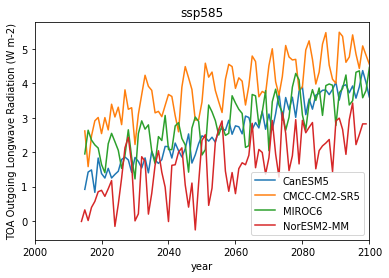

In [12]:
print(tsfiles)

# set cdo to an incidence of Cdo(), you don't need to do this, but cdo.func is neater than Cdo().func
cdo = Cdo()
s0d4=1361./4.
# lets add the two together:
for i,model in enumerate(models):
    f1=odir+"rlut_Amon_"+model+"_ssp585_r1i1p1f1_gn_fldmean_yearmean.nc"
    f2=odir+"rsut_Amon_"+model+"_ssp585_r1i1p1f1_gn_fldmean_yearmean.nc"
    tmpfile=cdo.addc(s0d4,input=cdo.mulc(-1,input=cdo.add(input=[f1,f2])))
    var="rlut"
    if i==0:
        fig,ax=plot_base(str(tmpfile),var)
    else:
        plot_add(tmpfile,var,ax)
# uncomment if you only want to 2100
ax.set_xlim([2000,2100])
#ax.set_ylim([287,295])
ax.legend()

what do we see...

- is the radiative flux imbalance zero in 2015, if not why not?
- what happens to the flux imbalance over time, is it growing or shrinking and why ?
- is the rate of change linear or does it begin to slow down with some models, why do you think this is?
- Compare the flux imbalance in 2100 with the plot of the RCP radiative forcing, is it larger or smaller in magnitude?  Why is this? 



what have we learned today?  Well the change in TOA flux imbalance over time does not look like the nice linear plots of $\Delta F - \Delta T$ that we saw in the hand out - THOSE were for an idealized experiment where CO2 was suddenly turned up in a pulse (doubled or quadrupled typically) - In that case you suddenly hit the model hard and then watch as it adjusts over time... the planet warms and the TOA flux imbalance is reduced until balance is restored at the new warmer equilibrum temperature.   Here, the CO2 is slowly turned up over time (along with other greenhouse gases), so why doesn't the planet adjust (warm) and keep the fluxes close to balance.  Well that is the slow timescales for ocean heat uptake, the earth system just can't keep up, especially for RCP8p5 and the imbalance grows in time - it is still less than the radiative forcing, since the temperature is adjusting, but not fast enough to prevent the imbalance from growing. Thus you can see that at any point in time, there is a lot of "latent warming" locked in...  The only way one could prevent that future warming from being realized if it one could remove CO2 from the atmosphere. Simply moving to carbon neutral is not enough, that locked in warming will occur until TOA balance is restored. 

Now tell me, that WAS fun wasn't it?

# Class assessment

- Choose 8 models at random and 4 RCPs and plot global mean annual surface temperature rises from 2015 to 2100. What is the main cause of uncertainty in the first 30 years and what in the main cause of uncertainty in the last 30 years?  What other causes of uncertainty are there which should also be taken into account?
- Take 5 models that have contributed to BOTH CMIP5 and CMIP6 - plot global mean surface temperature changes for RCP8p5 for each model and both CMIP rounds...  Are the temperature changes identical, and if not explain why not? Are the differences between CMIP5 and CMIP6 for specific models larger or smaller than changes due to RCP or climate model?
- Make a map of the temperature changes for a thirty year period at the end of century minus preindustrial times... i.e. the average for 2070-2099 minus the average for 1850-1880 (you can choose the exact period to suit you and the model, as file chunk sizes differ according to the model, or use cdo seldate) - Where are the largest temperature changes found around the globe, explain the differences you find.
- With CMIP5 (unfortunately the TOA clear sky fields are not available yet for CMIP6) get the TOA all-sky and clear-sky fluxes. Take the difference to calculate the SW and LW cloud forcing (try with one model first, but you can also extend to 3 or 4 others later to see if it impacts the results).  Then make a map of the future minus past changes in cloud radiative forcing.  Try to interpret these in terms of the cloud types and changes - feel free to make reference to the literature when interpreting the changes you see.


